In [1]:
from PIL import Image as pil_image
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

import torch
import torch.nn.functional as F

from torchvision import models as vmodels
from torchvision import datasets as vdatasets
from torchvision import transforms as transforms

from acol import ACoL

In [2]:
pipeline = transforms.Compose([
            transforms.Resize((197, 197)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

image_path = 'images/'
image_datasets = vdatasets.ImageFolder(image_path, pipeline)
dataloader = torch.utils.data.DataLoader(image_datasets, batch_size=4)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
def load_acol(weight_path, model, cls_recipe, nb_classes, 
             deltas, device):
    base_model = vmodels.__dict__[model]()
    acol = ACoL(base_model, cls_recipe, nb_classes, deltas, device)
    acol.load_state_dict(torch.load(weight_path, map_location='cpu'))
    acol.eval()
    return acol

def calculate_prob(output, labels):
    softmax_val = F.softmax(output, dim=1)
    base = torch.zeros(output.size())
    one_hot = base.scatter(1, labels.view(-1 ,1), 1)
    prob = (softmax_val * one_hot).sum(1)
    return prob


In [4]:
acol_p = load_acol('../footballers2018_data/p/best_model_e08_val_acc0.78.pth.tar',
                  'resnet101', 'p', 4, [], device)
acol_pp06 = load_acol('../footballers2018_data/pp0.6/best_model_e06_val_acc0.79.pth.tar',
                     'resnet101', 'pp', 4, [0.6], device)
acol_pp09 = load_acol('../footballers2018_data/pp0.9/best_model_e07_val_acc0.80.pth.tar',
                     'resnet101', 'pp', 4, [0.9], device)
acol_pn06 = load_acol('../footballers2018_data/pn0.6/best_model_e08_val_acc0.79.pth.tar',
                     'resnet101', 'pn', 4, [0.6], device)
acol_pn09 = load_acol('../footballers2018_data/pn0.9/best_model_e10_val_acc0.81.pth.tar',
                     'resnet101', 'pn', 4, [0.6], device)

In [5]:
models = {'acol_p': {'model': acol_p},
          'acol_pp_06': {'model': acol_pp06},
          'acol_pp_09': {'model': acol_pp09},
          'acol_pn_06': {'model': acol_pn06},
          'acol_pn_09': {'model': acol_pn09}}

In [6]:
inputs, labels = iter(dataloader).next()

In [7]:
for mod in models.keys():
    outputs, cams = models[mod]['model'](inputs, labels)
    prob = calculate_prob(outputs[0], labels)
    models[mod]['outputs'] = outputs
    
    fused = torch.zeros(cams[0].size())
    cls_recipe = mod.split("_")[1]
    for idx, cls in enumerate(cls_recipe):
        if cls == 'p':
            fused = torch.max(fused, cams[idx])
    
    models[mod]['fused'] = fused.detach()
    models[mod]['prob'] = prob

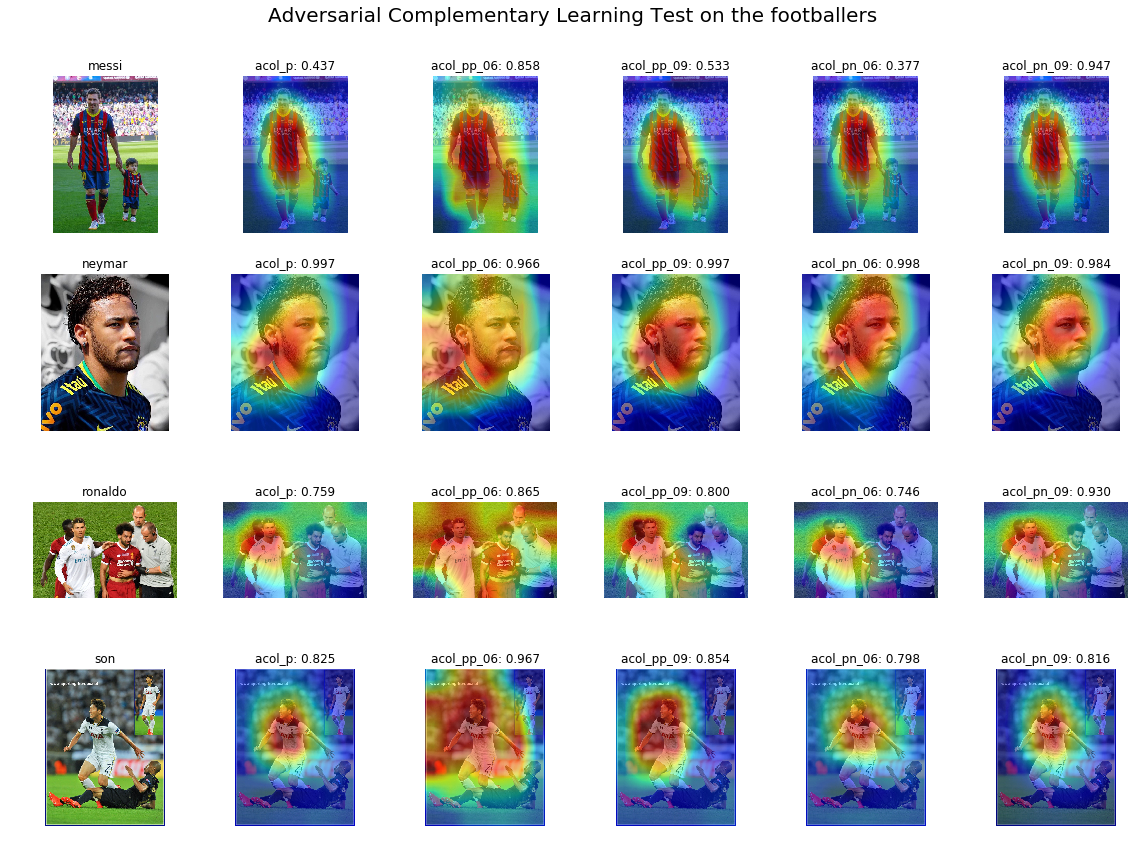

In [8]:
nrows = inputs.size()[0]
ncols = len(models) + 1
fig, ax = plt.subplots(nrows, ncols, figsize=(nrows * 4, ncols * 2))
for idx in range(inputs.size()[0]):
    
    org_img = pil_image.open(image_datasets.imgs[idx][0])
    h, w, c = np.asarray(org_img).shape
    resize = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((h, w)),
        transforms.ToTensor()
    ])
    
    ax[idx, 0].imshow(org_img)
    ax[idx, 0].set_title("{}".format(image_datasets.classes[idx]))
    
    for mod_idx, mod in enumerate(models.keys()):
        resized_fuse = resize(models[mod]['fused'][idx].unsqueeze(0))[0].numpy()
        ax[idx, mod_idx + 1].imshow(org_img)
        ax[idx, mod_idx + 1].imshow(resized_fuse, cmap='jet', alpha=0.5)
        ax[idx, mod_idx + 1].set_title("{}: {:.3f}".format(mod, models[mod]['prob'][idx]))
    
for a in ax:
    for b in a:
        b.axis("off")
plt.suptitle("Adversarial Complementary Learning Test on the footballers", fontsize=20)
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()